# COSC 4337 - Homework 4: Generative Adversarial Networks (GANs) 🎨

**Objective:** The goal of this assignment is to build, train, and evaluate a basic Generative Adversarial Network (GAN) capable of generating novel, realistic-looking handwritten digits.

***Note on Frameworks***

This notebook uses `Keras` with a `TensorFlow` backend. This assignment is more complex than previous ones, as it requires a custom training loop. Pay close attention to the instructions for training the Generator and Discriminator separately.

## Problem Statement

You are tasked with building a system that can **generate** new images of handwritten digits (0-9). You will not be classifying existing images; you will be creating *new* ones that look like they could have come from the original dataset.

**Dataset:**
We will use the **MNIST dataset**, which contains 60,000 training images of handwritten digits (28x28 pixels).

**Core GAN Concepts:**
A GAN consists of two competing neural networks:
1.  **The Generator (G):** The 'artist' or 'counterfeiter'. Its job is to take random noise (called *latent noise*) as input and try to create a fake image that looks real.
2.  **The Discriminator (D):** The 'art critic' or 'detective'. Its job is to look at an image (either real from the dataset or fake from the generator) and decide if it is **real (1)** or **fake (0)**.

**The Training "Minimax" Game:**
* The **Discriminator** is trained to get better at telling real and fake images apart.
* The **Generator** is trained to fool the Discriminator into thinking its fake images are real.

Over time, the Generator gets better at making realistic images, and the Discriminator gets better at spotting fakes. This "adversarial" competition pushes the Generator to produce highly realistic results.





In [1]:
# === Import Libraries ===
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import random

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, Dropout, Input
from keras.optimizers import Adam

# === Set Seed ===
seed = 4337
np.random.seed(seed)
random.set_seed(seed)

## Part 1: Data Loading and Preprocessing

### 1a. Load the MNIST Dataset

We Loading the 60,000 training images from Keras using `mnist.load_data()`.
This gives us the "real" data that the Discriminator will learn from and the Generator will try to imitate. Note that for GANs, we don't need the labels (`y_train`, `y_test`), so we can ignore them (using `_` as a placeholder).

In [2]:
# === 1. Load Data ===
# We only need the training images (X_train). We don't need the labels (y_train)
# because GANs are an unsupervised learning method.
# YOUR CODE HERE: Load the MNIST dataset. Store the training images in 'X_train'.
# You can use '_' to ignore the other returned arrays (y_train, X_test, y_test).
(X_train, _), (_, _) = mnist.load_data()

print(f"Shape of training data: {X_train.shape}")

Shape of training data: (60000, 28, 28)


### 1b. Reshape and Scale the Data

We are converting the 28x28 pixel images into flat vectors and scaling their values from [0, 255] to [-1, 1].
Using `.reshape()` to flatten the images. Then, performing a mathematical operation `(image - 127.5) / 127.5`.
1.  **Reshaping:** Our initial GAN will use simple `Dense` layers, which expect flat vectors (784 features) as input, not 2D images (28x28).
2.  **Scaling to [-1, 1]:** This is a best practice for GANs. The Generator's output layer will use a `tanh` activation function, which outputs values in the [-1, 1] range. We *must* scale our real images to match this same range so the Discriminator can make a fair comparison.

In [3]:
# === 2. Reshape and Scale ===
# our images are 28x28. We need to flatten them to 784-dimensional vectors.
image_size = X_train.shape[1] * X_train.shape[2]   # 28 * 28 = 784

# Reshape X_train. New shape: (60000, 784)
X_train = X_train.reshape(X_train.shape[0], image_size)

# Scale the data from [0, 255] to [-1, 1]
# This pairs with the 'tanh' activation in the Generator output.
X_train = X_train.astype("float32")
X_train = (X_train - 127.5) / 127.5

print(f"Shape of data after reshaping: {X_train.shape}")
print(f"Data min value after scaling: {np.min(X_train)}")
print(f"Data max value after scaling: {np.max(X_train)}")

Shape of data after reshaping: (60000, 784)
Data min value after scaling: -1.0
Data max value after scaling: 1.0


### 1c. Define Constants

* `latent_dim`: The size of the random noise vector (e.g., 100) that will be fed into the Generator.
* `img_shape`: The shape of our flattened image (784).

In [4]:
# === 3. Define Constants ===
latent_dim = 100
img_shape = (image_size,)

print(f"Latent (noise) vector dimension: {latent_dim}")
print(f"Image vector shape: {img_shape}")

Latent (noise) vector dimension: 100
Image vector shape: (784,)


## Exercise 1: Build the GAN Components

We will now build the two separate models: the Generator and the Discriminator.

### 1a. Build the Generator (The "Artist")

We will build A neural network that takes a 100-dim noise vector and outputs a 784-dim vector (a fake image).
 Use a `Sequential` model. We'll use `Dense` layers with `LeakyReLU` activation (a common choice for GANs) to upsample the noise into a full image.
The final layer **must** use `tanh` activation. This forces the Generator's output to be in the [-1, 1] range, matching the scaled real images.

In [5]:
def build_generator():
    model = Sequential(name="Generator")

    # Input layer (takes 100-dim noise)
    # Add a Dense layer with 256 units, LeakyReLU activation, and input_dim=latent_dim
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))

    # Hidden layer
    # Add a Dense layer with 512 units and LeakyReLU activation.
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))

    # Output layer
    # Add a Dense layer with 'image_size' units and 'tanh' activation.
    model.add(Dense(image_size, activation="tanh"))

    model.summary()
    return model

# Build the Generator
generator = build_generator()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 784)            │       402,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 559,632 (2.13 MB)

 Trainable params: 559,632 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

### 1b. Build the Discriminator (The "Critic")

We will build a neural network that takes a 784-dim vector (an image) and outputs a single probability (0 = fake, 1 = real).
Use a `Sequential` model. This is a standard binary classifier. We use `Dense` layers with `LeakyReLU` and `Dropout` (to prevent overfitting).
The final layer **must** use `sigmoid` activation. This squashes the output to a probability between 0 and 1.

In [6]:
def build_discriminator():
    model = Sequential(name="Discriminator")

    # Input layer (takes 784-dim image vector)
    # Add a Dense layer with 512 units, LeakyReLU activation, and specify input_shape=img_shape
    model.add(Dense(512, input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    # Hidden Layer
    # Add a Dense layer with 256 units and LeakyReLU activation.
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    # Output Layer
    # Add a Dense layer with 1 unit and 'sigmoid' activation.
    model.add(Dense(1, activation='sigmoid'))

    model.summary()
    return model

# Build and compile the Discriminator
discriminator = build_discriminator()

# Compile the discriminator.
discriminator.compile(
    optimizer=Adam(0.0002, 0.5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Discriminator compiled.")


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

Discriminator compiled.


## Exercise 2: Build the Combined GAN Model

We are creating a third, "combined" model where the Generator's output is fed directly into the Discriminator (`G(noise) -> D`).
Use the Keras functional API (`Model`) to chain `generator` and `discriminator` together.
This combined model is used *only* to train the Generator. When we train this model, we will **freeze the Discriminator's weights**. This way, all the error signals flow back and *only* update the Generator's weights, teaching it how to change its output to better fool the (currently frozen) Discriminator.

In [7]:
# === Build the Combined GAN Model ===

# Define the input for the combined model (this is the noise for the Generator)
# Create an Input layer with shape (latent_dim,)
z = Input(shape=(latent_dim,))

# Pass the noise through the Generator to create an image
# Pass 'z' (the input) into the 'generator' model.
img = generator(z)

# ==== FREEZE DISCRIMINATOR WEIGHTS ====
# Set the discriminator's weights to be non-trainable.
# We only want to update the generator's weights when training the combined model.
discriminator.trainable = False

# Pass the generated image (img) through the (frozen) Discriminator
validity = discriminator(img)

# Create the combined model
# Input is 'z' (noise), Output is 'validity' (0 or 1)
# Create the combined 'Model' (from keras.models).
# It takes 'z' as input and 'validity' as its output.
gan = Model(z, validity)

# Compile the Combined GAN ----
# This compilation only affects the Generator (since D is frozen).
# Compile the 'gan' model.
# Use 'Adam' optimizer and 'binary_crossentropy' loss.
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

print("\n=== Combined GAN Model Summary ===")
gan.summary()
print("\nIs Discriminator trainable in GAN model? (discriminator.trainable)", discriminator.trainable)



=== Combined GAN Model Summary ===


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Generator (Sequential)          │ (None, 784)            │       559,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator (Sequential)      │ (None, 1)              │       533,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,093,137 (4.17 MB)

 Trainable params: 559,632 (2.13 MB)

 Non-trainable params: 533,505 (2.04 MB)


Is Discriminator trainable in GAN model? (discriminator.trainable) False


## Exercise 3: Create the Custom Training Loop

We are writing the code that alternates between training the Discriminator and the Generator.
We'll write a `for` loop that runs for a set number of epochs. Inside this loop, we will:
1.  **Train Discriminator:** a. Get a batch of real images from `X_train`. Label them as `1` (real).
    b. Generate a batch of fake images using `generator.predict()`. Label them as `0` (fake).
    c. Train the discriminator on both batches using `discriminator.train_on_batch()`.
2.  **Train Generator:**
    a. Generate a batch of random noise.
    b. Create a set of "misleading" labels, all `1`s (real).
    c. Train the *combined `gan` model* using `gan.train_on_batch()`, passing in the noise and the misleading labels. This updates *only* the generator's weights.

 A simple `.fit()` won't work. We need this custom loop to manage the "minimax" game, ensuring one model doesn't overpower the other too quickly.

### 3a. Helper Function to Plot Images

A function to save a grid of our generated images.
We will call this function every few epochs to visually check our Generator's progress.

In [8]:
# === 3a. Helper Function to Plot Images ===
# This function is provided for you. You can just run it.

def plot_generated_images(epoch, generator, examples=16, dim=(4, 4), figsize=(7, 7)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generated_images = generator.predict(noise, verbose=0)  # set verbose=0 to avoid spam
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(f'Generated Images at Epoch {epoch}', y=1.03)
    plt.show()


### 3b. The Training Loop

**Instructions:** Fill in the `YOUR CODE HERE` sections inside the loop. This is the most important part of the assignment.

**Note:** Results will not look as good on 50 epochs but we are doing this to learn so it does not matter as much ! Adjust epochs according to your system

Starting Training...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.4982, acc.: 75.39%] [G loss: 0.6258]


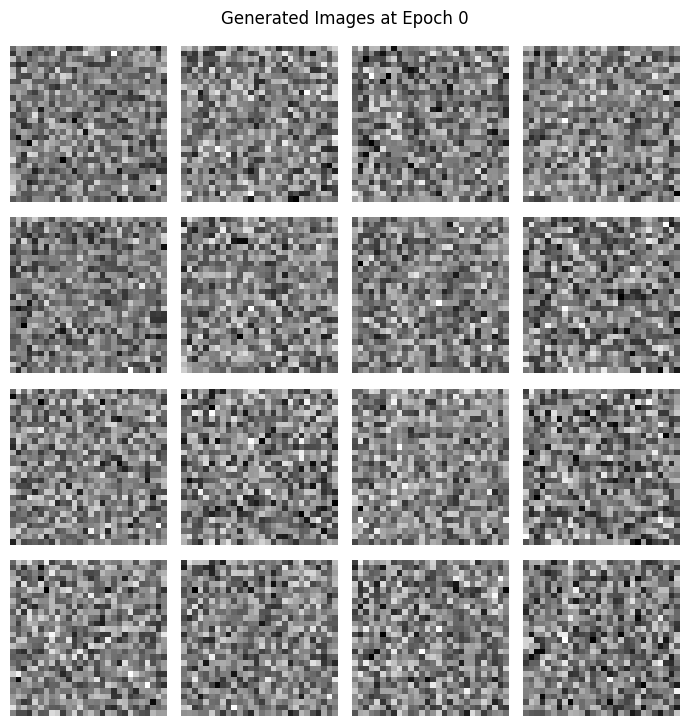

10 [D loss: 0.9846, acc.: 45.26%] [G loss: 0.2867]


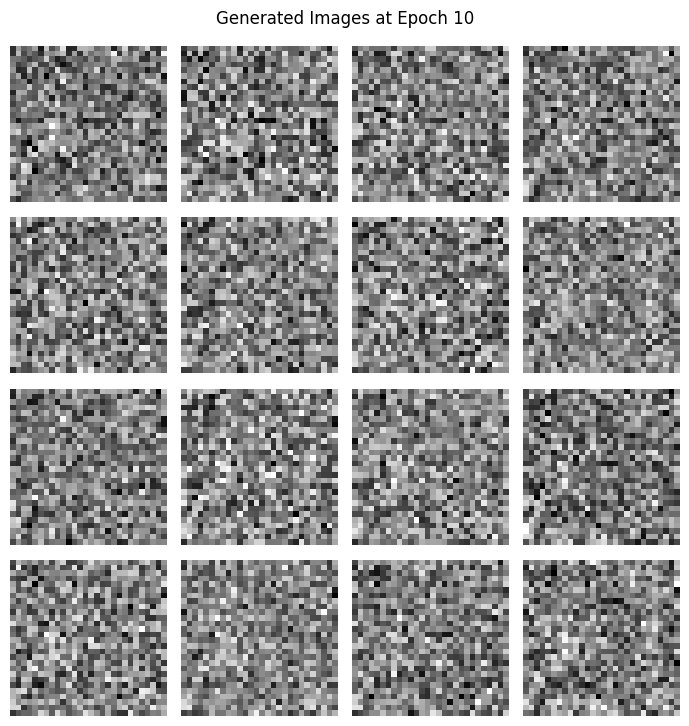

20 [D loss: 1.4008, acc.: 43.72%] [G loss: 0.1721]


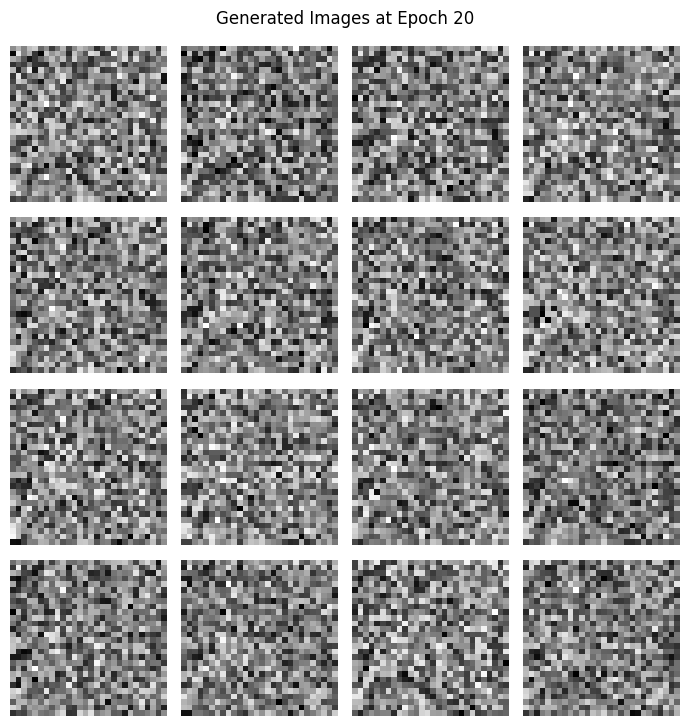

30 [D loss: 1.7178, acc.: 43.14%] [G loss: 0.1221]


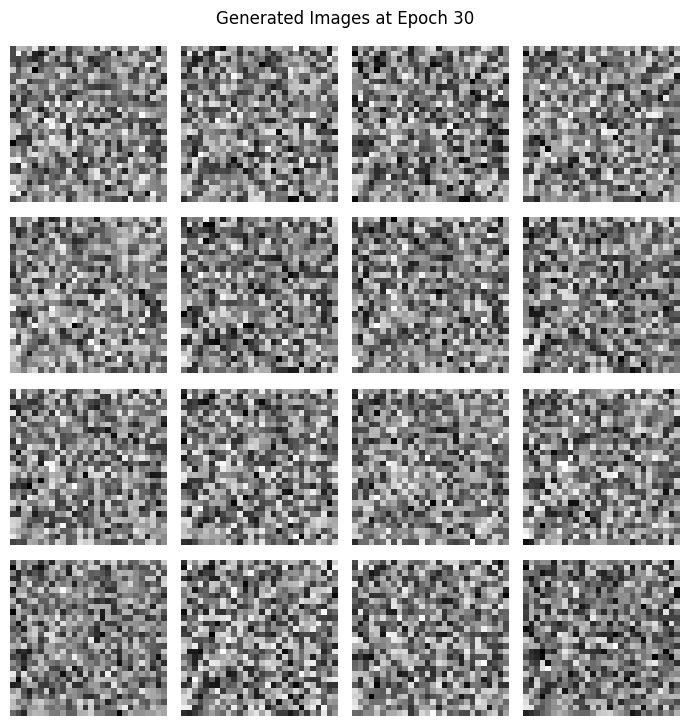

40 [D loss: 1.9715, acc.: 42.89%] [G loss: 0.0946]


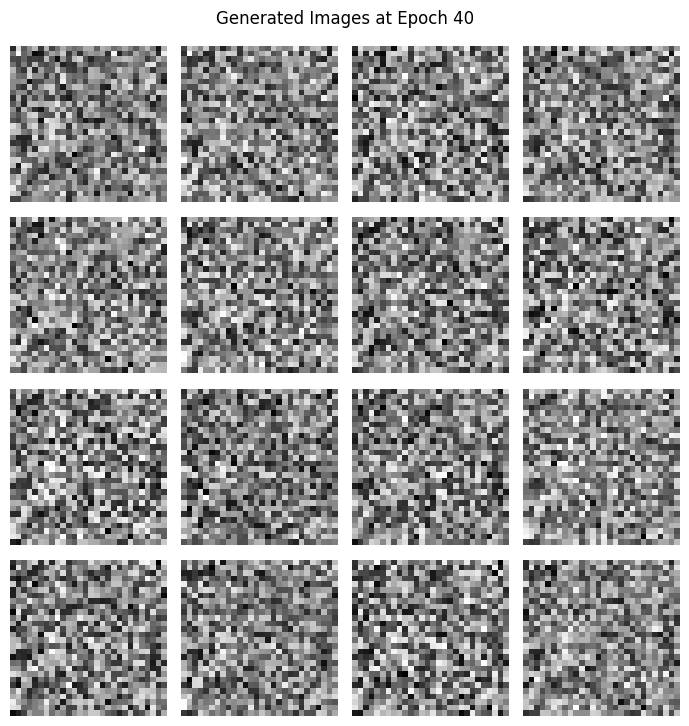

50 [D loss: 2.1714, acc.: 42.61%] [G loss: 0.0771]


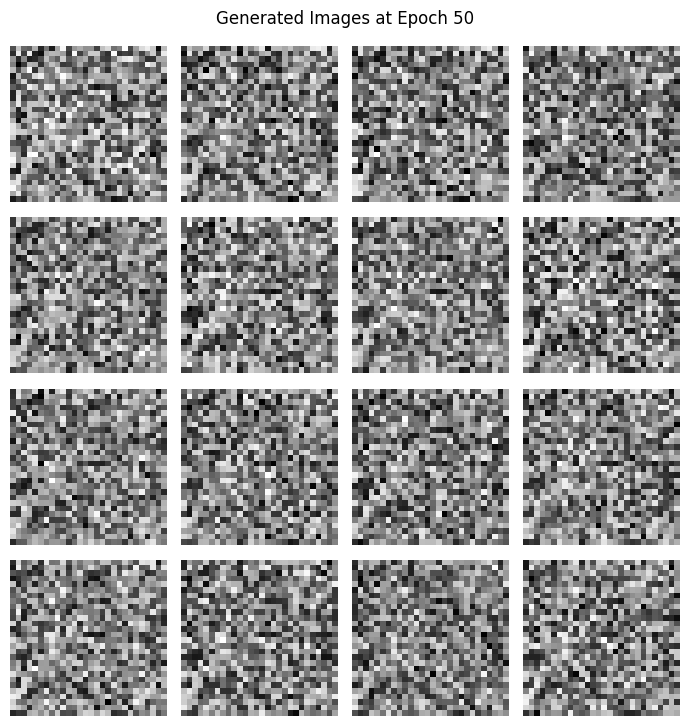

60 [D loss: 2.3437, acc.: 42.68%] [G loss: 0.0651]


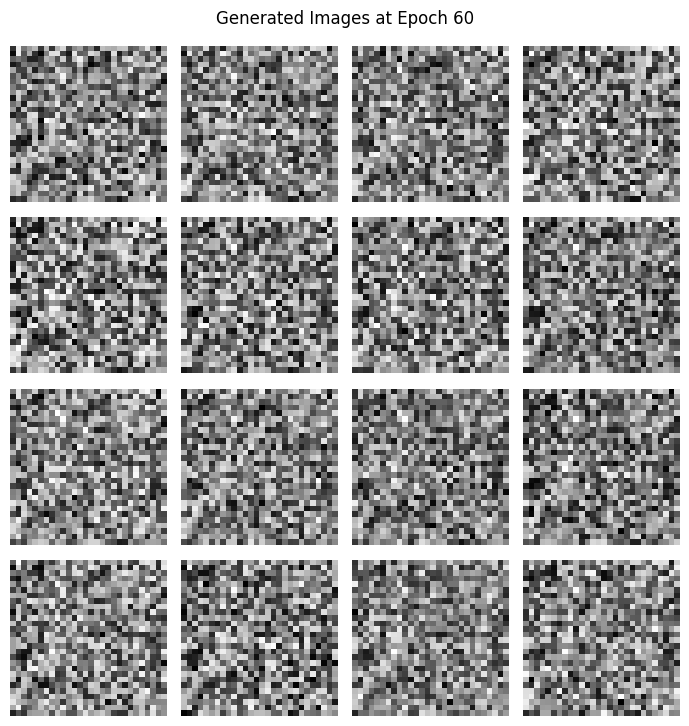

70 [D loss: 2.4880, acc.: 42.64%] [G loss: 0.0564]


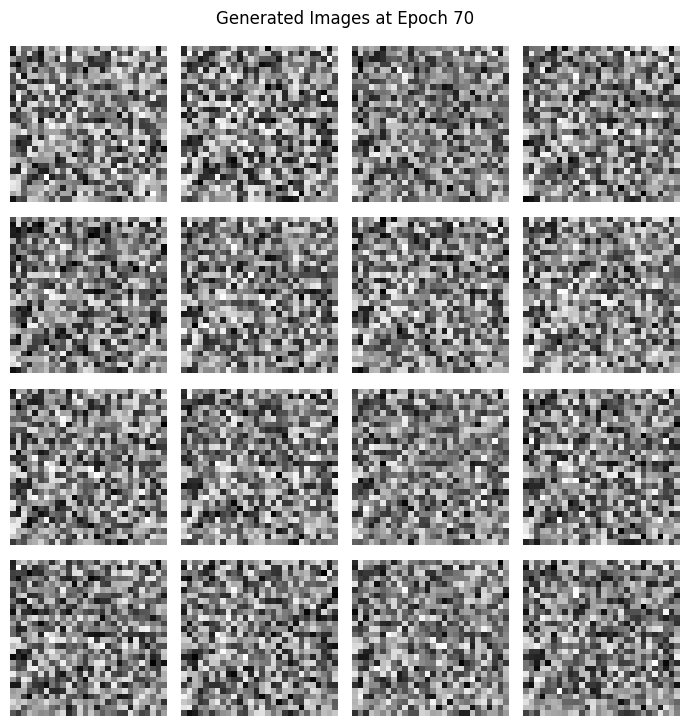

80 [D loss: 2.6138, acc.: 42.41%] [G loss: 0.0497]


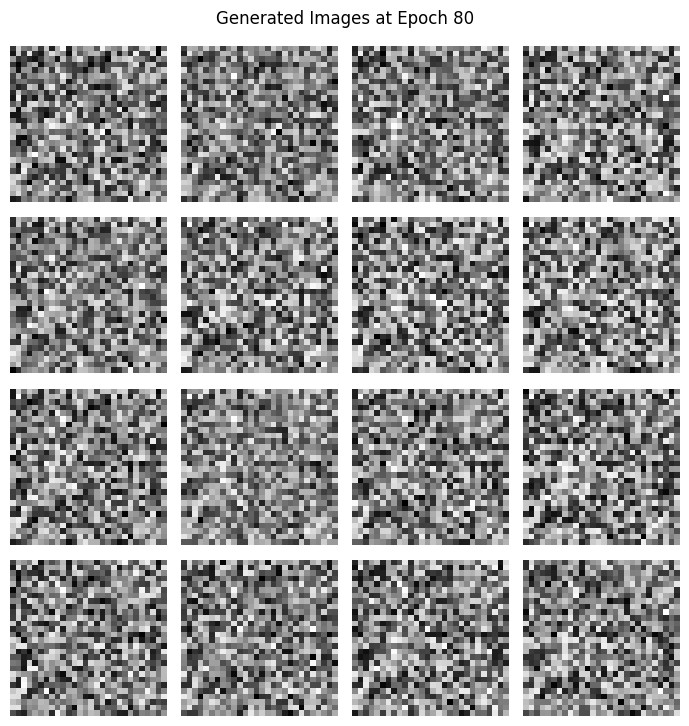

90 [D loss: 2.7230, acc.: 42.39%] [G loss: 0.0444]


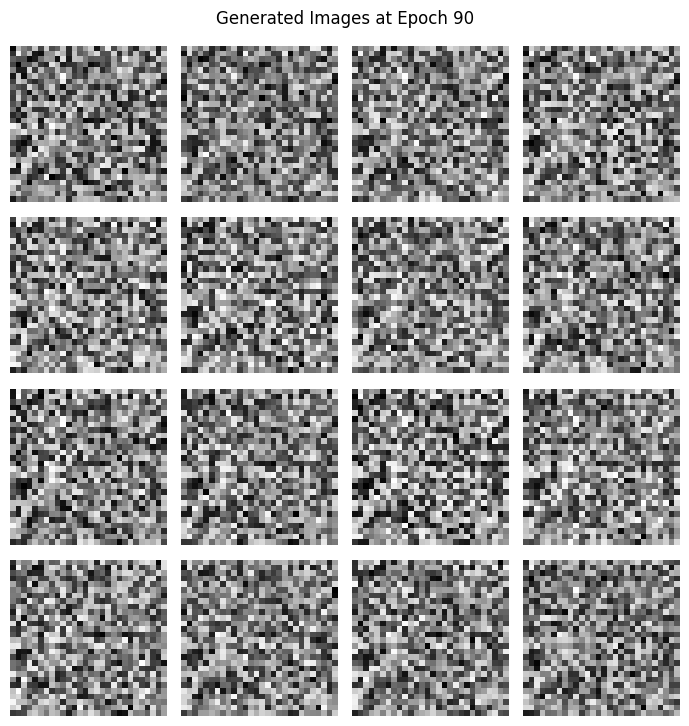

100 [D loss: 2.8221, acc.: 42.38%] [G loss: 0.0402]


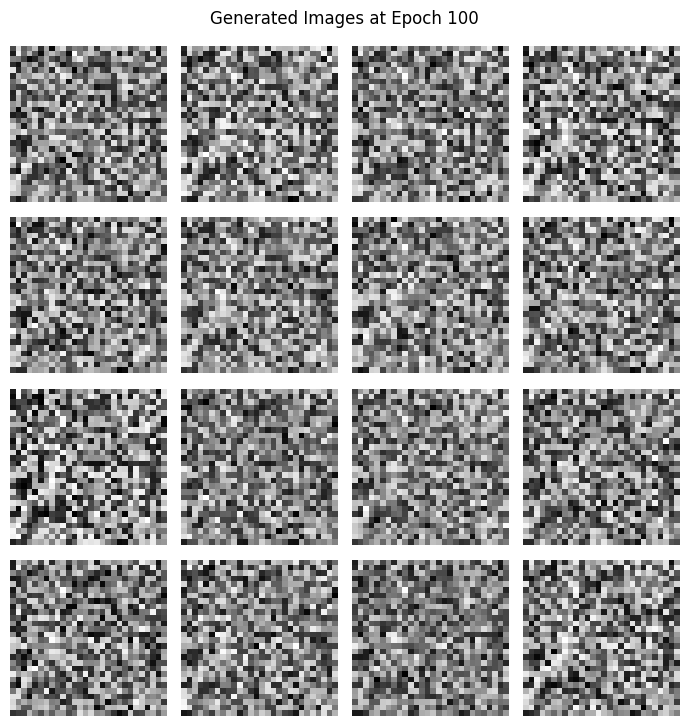

Training Complete! 🎉


In [9]:
# === 3b. The Training Loop ===

# --- Define Training Parameters ---
epochs = 100          # change if you want longer/shorter training
batch_size = 128
sample_interval = 10  # how often to save and plot generated images

# --- Initialize Arrays to Store Losses ---
d_losses = []
g_losses = []

# --- Create Ground Truth Labels ---
# Real labels (1s) and fake labels (0s) for the discriminator
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

# --- Start Training Loop ---
print("Starting Training...")
for epoch in range(epochs + 1):

    # =====================
    # 1. Train Discriminator
    # =====================

    # 1a. Get a random batch of real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_images = X_train[idx]

    # 1b. Generate a batch of fake images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_images = generator.predict(noise, verbose=0)

    # 1c. Train the discriminator on real images
    d_loss_real = discriminator.train_on_batch(real_images, real_labels)

    # 1d. Train the discriminator on fake images
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

    # Average the two discriminator losses
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # =================
    # 2. Train Generator
    # =================

    # 2a. Generate new noise
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # 2b. Train the generator via the combined GAN model.
    # We use 'real_labels' because we want the generator to fool the discriminator.
    g_loss = gan.train_on_batch(noise, real_labels)

    # -------- Logging & Plotting --------
    if epoch % sample_interval == 0:
        print(
            f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {d_loss[1]*100:.2f}%] "
            f"[G loss: {g_loss:.4f}]"
        )

        d_losses.append(d_loss[0])
        g_losses.append(g_loss)

        # Show generated samples
        plot_generated_images(epoch, generator)

print("Training Complete! 🎉")


## Exercise 4: Final Evaluation

### 4a. Plot Generator and Discriminator Losses

Plot the `g_loss` and `d_loss` that we saved during training.
Use matplotlib to plot the `d_losses` and `g_losses` lists on the same graph.
This helps visualize the "minimax" game. In an ideal (but rare) scenario, the losses would converge to a stable equilibrium. More commonly, you'll see them oscillate as one model gets temporarily better than the other.

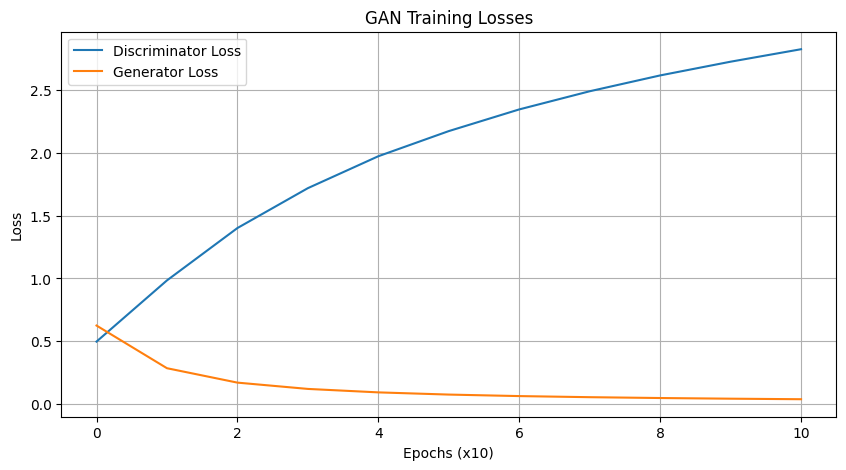

In [10]:
# === Plot Final Losses ===
plt.figure(figsize=(10, 5))

# Plot the 'd_losses' list. Label it 'Discriminator Loss'.
plt.plot(d_losses, label="Discriminator Loss")

# Plot the 'g_losses' list. Label it 'Generator Loss'.
plt.plot(g_losses, label="Generator Loss")

plt.title("GAN Training Losses")
# X-axis label is based on our sample_interval
plt.xlabel(f"Epochs (x{sample_interval})")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## Exercise 5: Analysis and Questions

**Instructions:** Answer the following questions based on the models you built and the results you obtained.

**1. Component Roles:** In your own words, what is the job of the **Generator**? What is the job of the **Discriminator**?

The job of the Generator is to take random noise as input and produce fake digit images that look as close as possible to the real MNIST digits. The job of the Discriminator is to look at an image and decide whether it is a real image from the training dataset or a fake image created by the Generator.

**2. Scaling and Activation:** * Why did we scale the *real* images (X_train) to the range [-1, 1]?
    * Which activation function did we use on the **Generator's** final layer, and why was this specific function chosen?

We scaled the real images to the range from -1 to 1 so that their pixel values match the range of the Generator’s outputs. This makes training more stable and fair because real and fake images are on the same scale. We used the tanh activation function in the last layer of the Generator because tanh also outputs values between -1 and 1, which fits this scaling.

**3. Training the Combined Model (The "Tricky" Part):**
    * When we trained the combined `gan` model (in Step 7 of the loop), which model's weights were actually being updated (Generator or Discriminator)?
    * Why did we have to **freeze** the weights of the other model before compiling the `gan` model?

When we trained the combined gan model, only the Generator’s weights were being updated. We had to freeze the weights of the Discriminator before compiling the gan model so that, during this step, the Discriminator acts as a fixed judge and the training signal only changes the Generator, teaching it how to better fool the current Discriminator.

**4. Misleading Labels:** When training the **Generator** (in Step 7 of the loop), we passed in a batch of `noise` and a batch of `real_labels` (all 1s). Why did we use labels for "real" images here? What were we trying to "trick"?

In [16]:
"When training the Generator, we fed in noise along with labels that said the images were real (all ones). We did this because we want the Generator to learn to make images that the Discriminator believes are real. In other words, we are trying to trick the Discriminator into calling fake images real so the Generator becomes better at creating realistic digits."

'When training the Generator, we fed in noise along with labels that said the images were real (all ones). We did this because we want the Generator to learn to make images that the Discriminator believes are real. In other words, we are trying to trick the Discriminator into calling fake images real so the Generator becomes better at creating realistic digits.'

**5. Loss Curve Analysis:** Look at your final "GAN Training Losses" plot.
    * Did the losses converge to a stable point, or did they oscillate (go up and down)?
    * What does it mean if the **Discriminator Loss (d_loss)** drops to near zero and stays there? Is this a good or bad outcome for training?
    * What does it mean if the **Generator Loss (g_loss)** drops to near zero? Is this good or bad?

In [18]:
"In the final GAN Training Losses plot, the losses did not settle at a flat point; instead, the Discriminator’s loss slowly went up while the Generator’s loss went down. If the Discriminator loss goes close to zero and stays there, it means the Discriminator is winning too easily, which is bad because the Generator stops learning much. If the Generator loss goes close to zero, it means the Generator is usually fooling the Discriminator; this can be good if the images look realistic, but it might also hide problems if the images are not very varied."

'In the final GAN Training Losses plot, the losses did not settle at a flat point; instead, the Discriminator’s loss slowly went up while the Generator’s loss went down. If the Discriminator loss goes close to zero and stays there, it means the Discriminator is winning too easily, which is bad because the Generator stops learning much. If the Generator loss goes close to zero, it means the Generator is usually fooling the Discriminator; this can be good if the images look realistic, but it might also hide problems if the images are not very varied.'

**6. Image Quality Analysis:** Look at the grid of images your generator produced.
    * Describe the progression. What did the images look like at the beginning versus the end?
    * Were the final images perfect? Did they look like recognizable digits, or were they still blurry/nonsensical? (This is known as "mode collapse" if it only produces one or two digits, or just noise).

In [20]:
"At the start of training, the generated images looked like random gray blobs and did not look like digits. After more training, some shapes started to look more like numbers, but many images were still blurry and messy. By the end, a few images looked like real handwritten digits, but many were still noisy, and some digits seemed to repeat, so the results were better than the start but still not perfect."

'At the start of training, the generated images looked like random gray blobs and did not look like digits. After more training, some shapes started to look more like numbers, but many images were still blurry and messy. By the end, a few images looked like real handwritten digits, but many were still noisy, and some digits seemed to repeat, so the results were better than the start but still not perfect.'

## 5. Deliverables

Please submit:
1.  This completed Jupyter Notebook file (`.ipynb`) with all code cells executed and outputs (including loss plots and generated image grids) clearly visible. (25% penalty for not doing so)
2.  An exported HTML version of this notebook (`File -> Download as -> HTML`). **(Important: 25% penalty if HTML is not submitted)**